# SweetTV Recommendation System
> building a tv-show and movie recommender system using lightfm and lightgbm models on sweet.tv's streaming dataset

- toc: true
- badges: true
- comments: true
- categories: [LightFM, HyperOpt, Kaggle, Movie, Streaming]
- image:

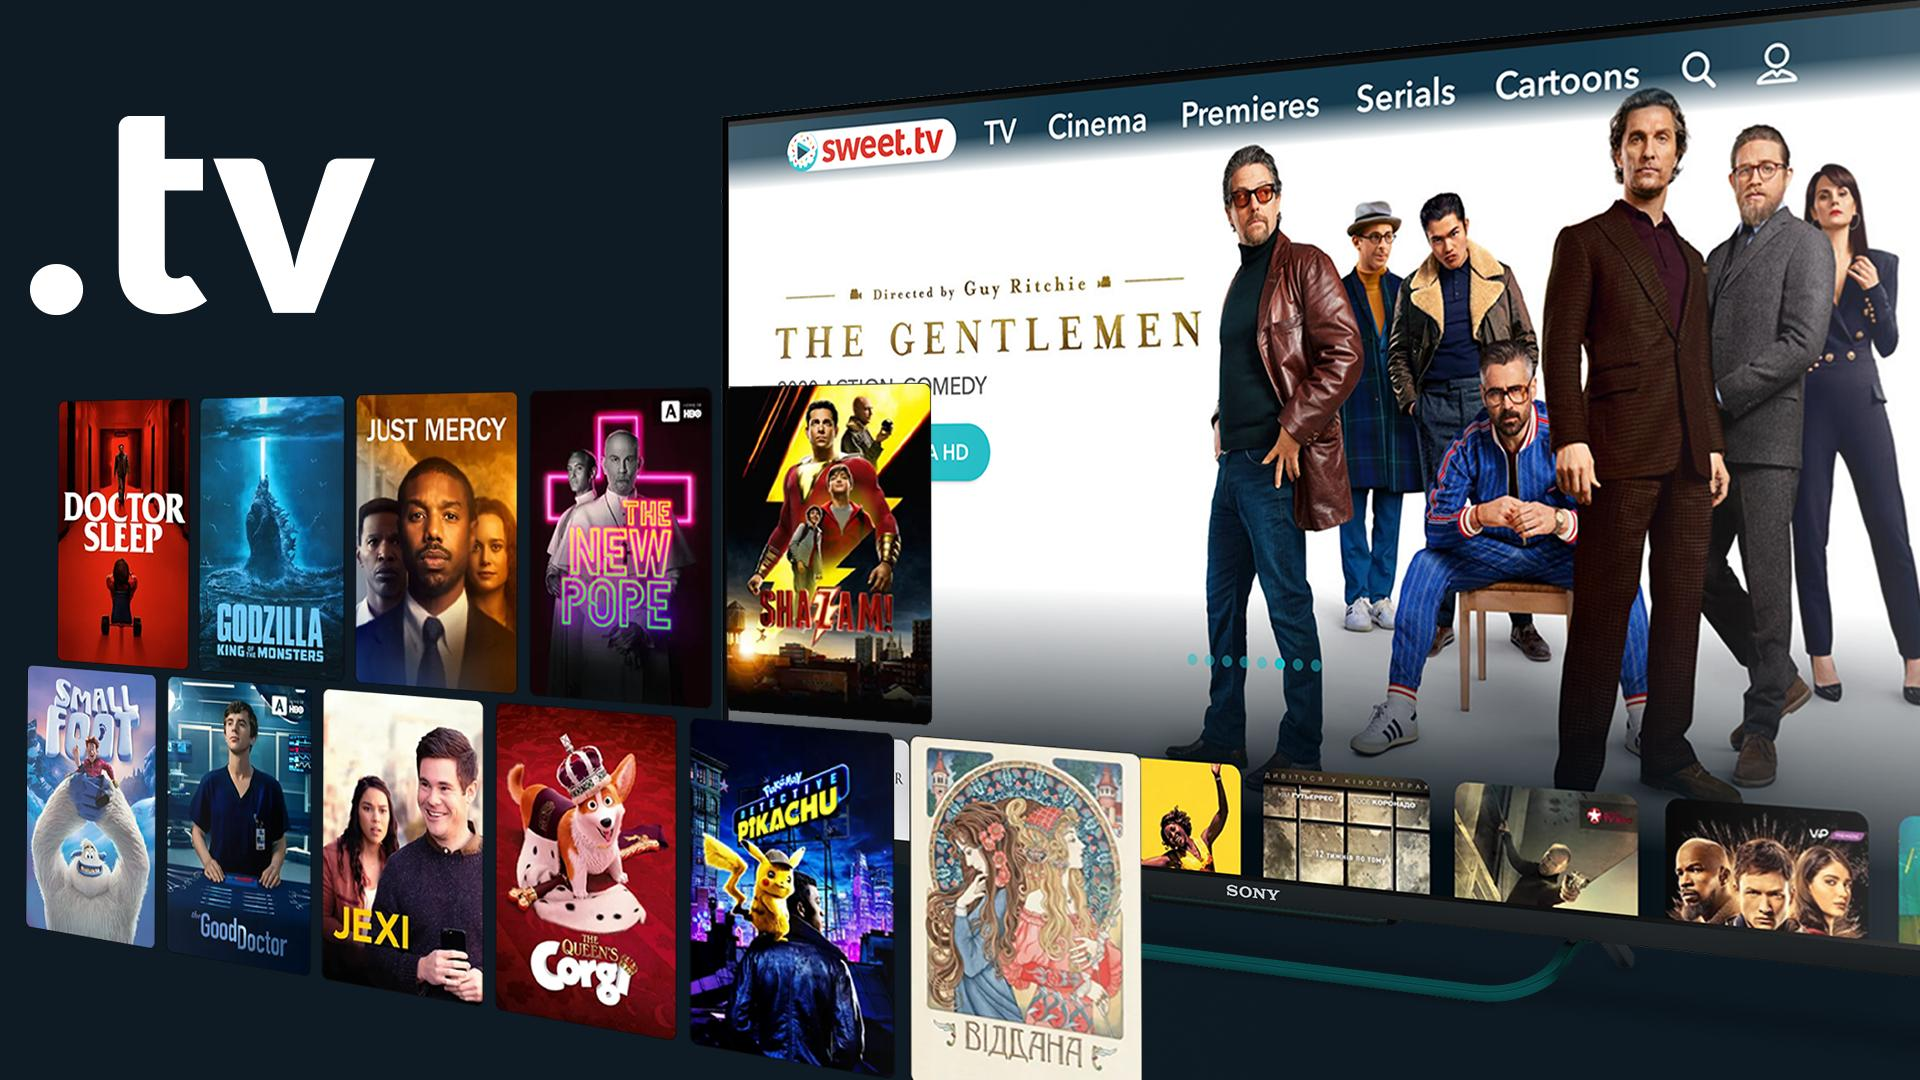

[sweet.tv](https://sweet.tv/en) is a streaming service that offers access to TV-channels, Ukrainian films, world-class movies, cartoons, and the best series

## Planning

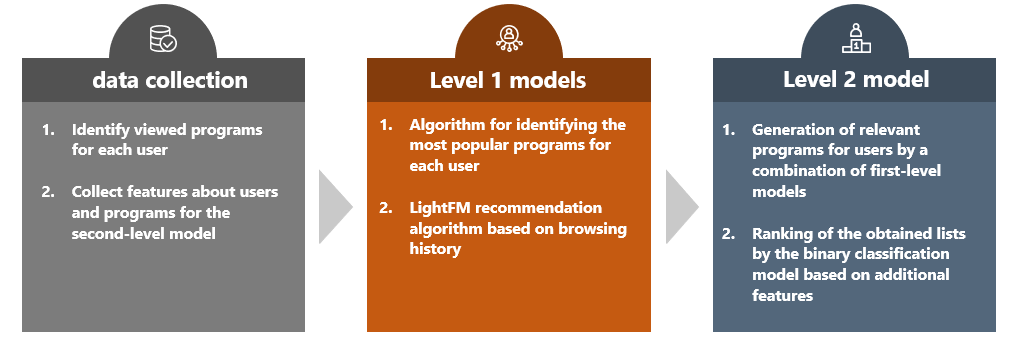

## Setup

In [ ]:
!pip install lightfm

In [ ]:
import ast
import tqdm
import scipy
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer

import lightgbm as lgb
from lightfm import LightFM
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import precision_at_k, auc_score
from lightfm.cross_validation import random_train_test_split

from hyperopt import hp, tpe
from hyperopt.fmin import fmin

%matplotlib inline
sns.set_style('whitegrid')

In [62]:
!pip install -q watermark
%reload_ext watermark
%watermark -m -iv

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.104+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

lightgbm  : 2.2.3
IPython   : 5.5.0
scipy     : 1.4.1
hyperopt  : 0.1.2
numpy     : 1.19.5
seaborn   : 0.11.1
matplotlib: 3.2.2
tqdm      : 4.41.1
pandas    : 1.1.5



## Data loading

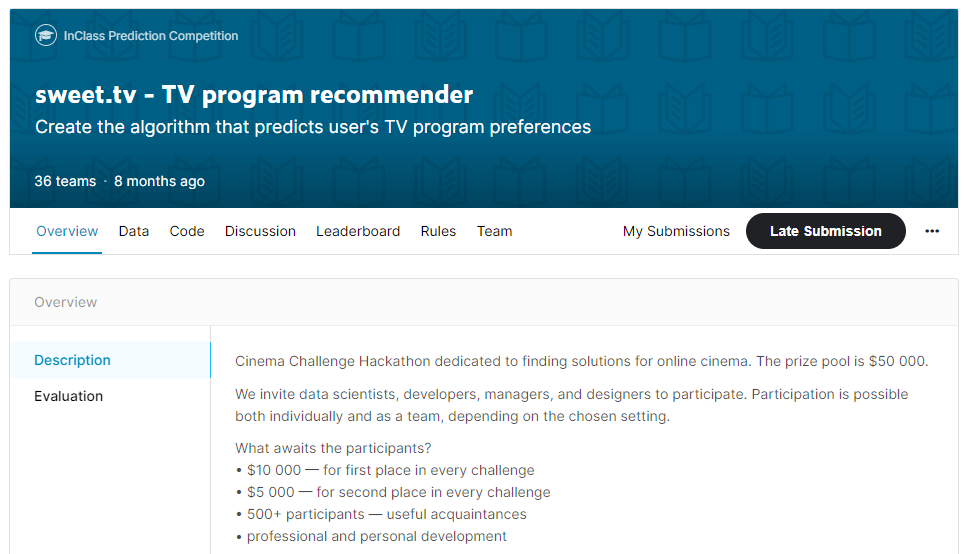

In [ ]:
!pip install -q -U kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c sweettv-tv-program-recommender

In [3]:
!unzip -qqo /content/sweettv-tv-program-recommender.zip

## EDA

**dataset11-30week.csv** - the training set. `vsetv_id` is the same as `channel_id` in export_arh_*.csv files.

In [5]:
df = pd.read_csv('dataset11-30.csv')
df.head()

user_id  vsetv_id  ...            stop_time duraton
0   3398461054087191302         6  ...  2020-03-09 00:01:53     111
1  17226860011138219284       353  ...  2020-03-09 00:03:26     204
2  18417531283109304442       332  ...  2020-03-09 00:01:26      81
3   3677642666679759206         7  ...  2020-03-09 01:07:41    4053
4  15105343836194894915       108  ...  2020-03-09 00:02:34     144

[5 rows x 5 columns]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5821987 entries, 0 to 5821986
Data columns (total 5 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   user_id     uint64
 1   vsetv_id    int64 
 2   start_time  object
 3   stop_time   object
 4   duraton     int64 
dtypes: int64(2), object(2), uint64(1)
memory usage: 222.1+ MB


In [7]:
df.start_time = pd.to_datetime(df.start_time)
df.stop_time = pd.to_datetime(df.stop_time)
df['date'] = df['start_time'].dt.date

In [8]:
df.describe(include='all', datetime_is_numeric=True).T

count unique  ...                  max         std
user_id     5.82199e+06    NaN  ...          1.84438e+19  5.2006e+18
vsetv_id    5.82199e+06    NaN  ...                 1531     572.814
start_time      5821987    NaN  ...  2020-07-26 23:58:42         NaN
stop_time       5821987    NaN  ...  2020-07-26 23:59:58         NaN
duraton     5.82199e+06    NaN  ...               342145     3123.74
date            5821987    139  ...                  NaN         NaN

[6 rows x 11 columns]

**export_arh_*.csv files** - supplemental information about train data (TV program schedule). Contains tv_show_id - have to predict 5 of these for the submission user_ids.

In [9]:
df_info = pd.read_csv('export_arh_11-20-final.csv').append(pd.read_csv('export_arh_21-30-final.csv'))
df_info.start_time = pd.to_datetime(df_info.start_time, format='%d.%m.%Y %H:%M:%S')
df_info['stop_time'] = df_info['start_time'] + pd.to_timedelta(df_info['duration'], unit='s')
df_info = df_info[df_info.tv_show_id != 0].copy().reset_index(drop=True)
df_info.head()

channel_id  ...           stop_time
0           3  ... 2020-03-09 09:10:00
1           3  ... 2020-03-09 11:30:00
2           3  ... 2020-03-09 20:15:00
3           3  ... 2020-03-10 00:10:00
4           3  ... 2020-03-10 02:05:00

[5 rows x 14 columns]

In [10]:
df_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237118 entries, 0 to 237117
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   channel_id          237118 non-null  int64         
 1   channel_title       237118 non-null  object        
 2   start_time          237118 non-null  datetime64[ns]
 3   duration            237118 non-null  int64         
 4   tv_show_title       237118 non-null  object        
 5   tv_show_id          237118 non-null  int64         
 6   tv_show_category    237118 non-null  object        
 7   tv_show_genre_1     226331 non-null  object        
 8   tv_show_genre_2     141357 non-null  object        
 9   tv_show_genre_3     43902 non-null   object        
 10  year_of_production  234747 non-null  object        
 11  director            205092 non-null  object        
 12  actors              205934 non-null  object        
 13  stop_time           237118 no

In [15]:
print('No. of users:', df.user_id.nunique())
print('No. of channels:', df.vsetv_id.nunique())
print('No. of TV shows:', df_info.tv_show_id.nunique())
print('Data dates:', df.start_time.min(), df.start_time.max())
print('Data dates info:', df_info.start_time.min(), df_info.start_time.max())

No. of users: 4914
No. of channels: 202
No. of TV shows: 8234
Data dates: 2020-03-09 00:00:02 2020-07-26 23:58:42
Data dates info: 2020-03-08 23:00:00 2020-07-27 06:00:00


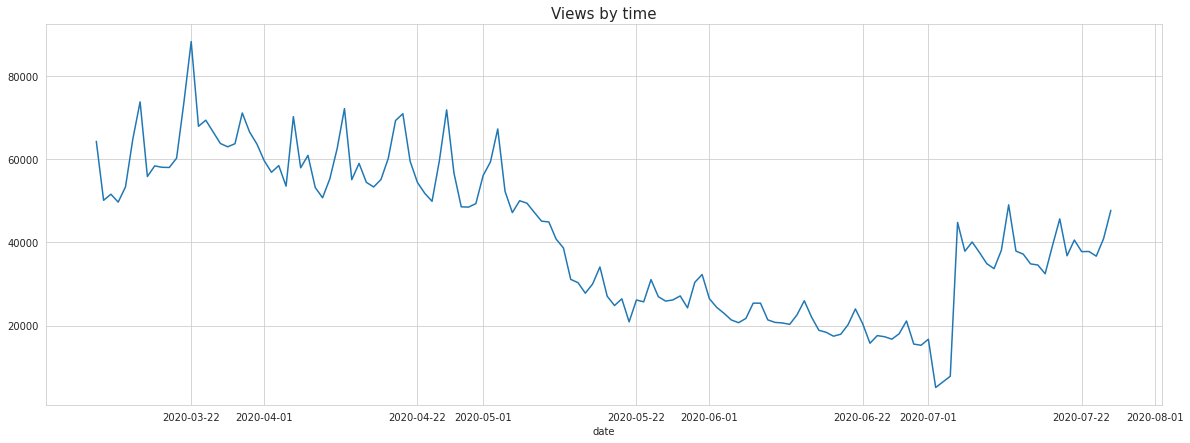

In [18]:
ax = df.groupby(['date']).size().plot(figsize = (20, 7));
ax.set_title('Views by time', fontsize = 15);

There are many signs in the names of TV programs - cinema, season, series, premiere

In [11]:
for c in ['эп.', 'м/с', 'х/ф', 'д/ф', 'м/ф', 'т/с', 'премьера']:
    c_index = df_info[df_info['tv_show_title'].str.lower().str.contains(c)].index

for c in ['c.', 'c..']:
    c_index = df_info[df_info['tv_show_title'].str.lower()==c].index

In [12]:
channel_info_df = df_info[['channel_id', 'channel_title']].drop_duplicates()
channel_info_df[channel_info_df.duplicated(['channel_id'], keep = False)].sort_values(['channel_id'])

channel_id             channel_title
27421           75                      Киев
27425           75                      Київ
40540          288           Русский экстрим
158230         288  Russian Extreme (HD REX)
99803         1249       UA:Перший (спутник)
217053        1249                 UA:Перший

In [23]:
show_info_df = df_info[['tv_show_id', 'tv_show_category', 'tv_show_genre_1', 
                        'tv_show_genre_2', 'tv_show_genre_3', 'year_of_production', 
                        'director', 'actors']].drop_duplicates()
show_info_df[show_info_df.duplicated(['tv_show_id'], keep = False)].sort_values(['tv_show_id']).head(3)

tv_show_id  ...                                   actors
100228      900954  ...  Сюзан Сарандон, Шон Пенн, Роберт Проски
87489       900954  ...  Сюзан Сарандон, Шон Пенн, Роберт Проски
92727      2000444  ...                                      NaN

[3 rows x 8 columns]

In [24]:
show_duration_df = df_info[['tv_show_id', 'duration']].drop_duplicates()
show_duration_df[show_duration_df.duplicated(['tv_show_id'], keep = False)].sort_values(['tv_show_id']).head(3)

tv_show_id  duration
37204       20088     10500
7           20088      1800
9           20088      3000

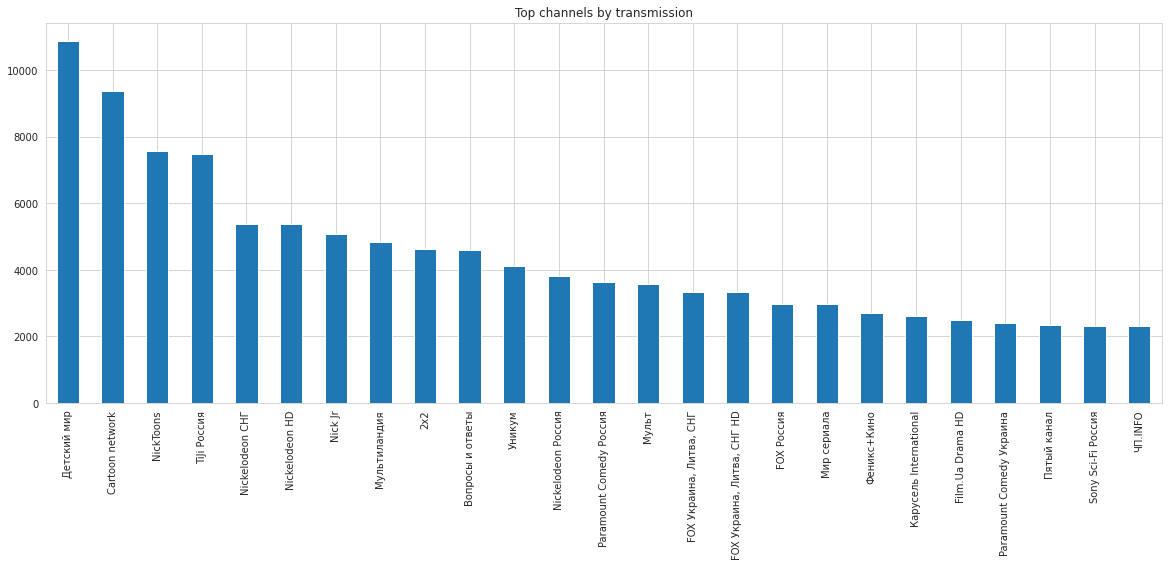

In [26]:
ax = df_info['channel_title'].value_counts()[:25].plot(figsize = (20, 7), kind = 'bar');
ax.set_title('Top channels by transmission');

In [27]:
tv_show_id_df = df_info[['tv_show_id', 'tv_show_title']].drop_duplicates()
tv_show_id_df[tv_show_id_df.duplicated(['tv_show_id'], keep = False)].sort_values(['tv_show_id']).head()

tv_show_id                    tv_show_title
7321       30066   'Наша Russia'. Дайджест, 1 эп.
7336       30066  'Наша Russia'. Дайджест, 16 эп.
7335       30066  'Наша Russia'. Дайджест, 15 эп.
7334       30066  'Наша Russia'. Дайджест, 14 эп.
7333       30066  'Наша Russia'. Дайджест, 13 эп.

## Preprocessing

**Algorithm for collecting data on TV program views**

In [ ]:
show_lines = []
for i, row in tqdm(df.iterrows(), total = df.shape[0]):
    
    user_id = row['user_id']
    vsetv_id = row['vsetv_id']
    start_time = row['start_time']
    stop_time = row['stop_time']
    
    # For each user session, we will find those programs that went on the channel that he watched
    shows_remember_df = df_info[(df_info.channel_id == vsetv_id) 
                    & (df_info.start_time < stop_time) 
                    & (df_info.stop_time > start_time)][['tv_show_id', 'start_time', 'stop_time']].copy()
    
    # Remember which programs the user has watched
    for j, row_j in shows_remember_df.iterrows():
        show_lines.append([user_id, vsetv_id, start_time, stop_time, row_j['tv_show_id'], row_j['start_time'], row_j['stop_time']])
        
show_lines_df = pd.DataFrame(show_lines,columns = ['user_id', 'vsetv_id', 'start_time', 'stop_time', 'tv_show_id', 'show_start_time', 'show_stop_time'])
show_lines_df.to_csv('dataset_with_shows.csv', index = False)

## Feature engineering

In [18]:
def prepare_features(train, train_info, train_info_future, train_base):
    
    '''
    Function to enrich data by adding features
    '''

    final_shape = train.shape[0]
    
    # collect prediction rank
    for user, group in train.sort_values(['user_id', 'user_show_freq'], ascending = False).groupby(['user_id']):
        train.loc[group.index, 'user_show_rank'] = np.arange(0, group.shape[0])
    train.loc[train[train.user_show_freq == 0].index, 'user_show_rank'] = 50

    # collect prediction rank
    for user, group in train.sort_values(['user_id', 'lightfm_score'], ascending = False).groupby(['user_id']):
        train.loc[group.index, 'user_lfm_rank'] = np.arange(0, group.shape[0])
    train.loc[train[pd.isnull(train.lightfm_score)].index, 'user_lfm_rank'] = 50

    # mean rank
    train['combined_rank'] = (train['user_show_rank'] + train['user_lfm_rank']) / 2

    # tv show channel
    _temp = train_info[['tv_show_id', 'channel_id']].drop_duplicates()
    _temp = _temp[~_temp.duplicated(['tv_show_id'], keep = 'first')].copy()
    train = train.merge(_temp, on = ['tv_show_id'], how = 'left')
    assert final_shape == train.shape[0]

    # add cat ids
    _temp = train_info[['tv_show_id', 'tv_show_category', 'tv_show_genre_1', 'tv_show_genre_2', 'tv_show_genre_3']].drop_duplicates()
    _temp = _temp[~_temp.duplicated(['tv_show_id'], keep = 'first')].copy()
    train = train.merge(_temp, on = ['tv_show_id'], how = 'left')
    assert final_shape == train.shape[0]
    
    # number of watches with diff thresholds
    for threshold in [0.3, 0.8]:
        c_new = f'user_show_freq_{threshold}'
        features_threshold = get_features(train_base, threshold=threshold)
        features_threshold.rename(columns = {'user_show_freq':c_new}, inplace = True)
        train = train.merge(features_threshold, on = ['user_id', 'tv_show_id'], how = 'left')
        train[c_new].fillna(0, inplace = True)
        assert final_shape == train.shape[0]
        
    # alternative base
    total_user_show_watch_df = train_base.groupby(['tv_show_id', 'show_start_time', 'show_stop_time', 'user_id', 'show_duration'], as_index = False).user_watch_time.sum()
    total_user_show_watch_df['user_watch_perc'] = total_user_show_watch_df['user_watch_time'] / total_user_show_watch_df['show_duration']
    total_user_show_watch_df = total_user_show_watch_df[total_user_show_watch_df.user_watch_perc <= 1].copy()
    
    # number of watches with diff thresholds
    for threshold in [0.3, 0.5, 0.8]:
        c_new = f'alt_user_show_freq_{threshold}'
        features_threshold = get_features(total_user_show_watch_df, threshold=threshold)
        features_threshold.rename(columns = {'user_show_freq':c_new}, inplace = True)
        train = train.merge(features_threshold, on = ['user_id', 'tv_show_id'], how = 'left')
        train[c_new].fillna(0, inplace = True)
        assert final_shape == train.shape[0]
    

    # number of watches with more recent time splits
    for weeks_prior in [1]:
        c_new = f'user_show_freq_week_{weeks_prior}'
        split_date = train_base.start_time.max() - datetime.timedelta(days = weeks_prior * 7)
        features_split = get_features(train_base[train_base.start_time >= split_date], 200)
        features_split.rename(columns = {'user_show_freq':c_new}, inplace = True)
        train = train.merge(features_split, on = ['user_id', 'tv_show_id'], how = 'left')
        train[c_new].fillna(0, inplace = True)
        assert final_shape == train.shape[0]
        
        train[f'user_show_freq_dif_week_{weeks_prior}'] = (train['user_show_freq'] - train[c_new]) / train['user_show_freq']
        assert final_shape == train.shape[0]
        
        # new ranks
        for user, group in train.sort_values(['user_id', f'user_show_freq_week_{weeks_prior}'], ascending = False).groupby(['user_id']):
            train.loc[group.index, f'user_show_rank_week_{weeks_prior}'] = np.arange(0, group.shape[0])
        train[f'user_show_rank_mean_week_{weeks_prior}'] = train[['user_show_rank', f'user_show_rank_week_{weeks_prior}']].mean(axis = 1)
        assert final_shape == train.shape[0]
        
        train.drop(c_new, 1, inplace = True)
    
    # number of watches with more recent time splits
    for weeks_prior in [1]:
        c_new = f'alt_user_show_freq_week_{weeks_prior}'
        split_date = total_user_show_watch_df.show_start_time.max() - datetime.timedelta(days = weeks_prior * 7)
        features_split = get_features(total_user_show_watch_df[total_user_show_watch_df.show_start_time >= split_date], 200)
        features_split.rename(columns = {'user_show_freq':c_new}, inplace = True)
        train = train.merge(features_split, on = ['user_id', 'tv_show_id'], how = 'left')
        train[c_new].fillna(0, inplace = True)

        train[f'alt_user_show_freq_dif_week_{weeks_prior}'] = (train['user_show_freq'] - train[c_new]) / train['user_show_freq']

        # new ranks
        for user, group in train.sort_values(['user_id', c_new], ascending = False).groupby(['user_id']):
            train.loc[group.index, f'user_show_rank_week_{weeks_prior}'] = np.arange(0, group.shape[0])
        train[f'alt_user_show_rank_mean_week_{weeks_prior}'] = train[['user_show_rank', f'user_show_rank_week_{weeks_prior}']].mean(axis = 1)

        train.drop(c_new, 1, inplace = True)

    # Насколько часто пользователь смотрит канал
    _temp = train.groupby(['user_id', 'channel_id']).size().reset_index().rename(columns = {0:'user_channel_count'})
    _temp = _temp.merge(_temp.groupby(['user_id'], as_index = False)['user_channel_count'].sum().rename(columns = {'user_channel_count':'user_count'}),
                on = ['user_id'], how = 'left')
    train = train.merge(_temp[['user_id', 'channel_id', 'user_channel_count']],
                on = ['user_id', 'channel_id'], how = 'left')
    
    # user gruop watch mean time+ rel to every watch
    train = train.merge(train.groupby(['user_id'], as_index = False)['user_show_freq'].mean().rename(columns = {'user_show_freq':'group_user_show_freq'}),
                on = ['user_id'], how = 'left')
    train['user_show_freq_rel_group'] = train['user_show_freq'] / train['group_user_show_freq']
    assert final_shape == train.shape[0]

    # show total duration in the future and relative to previous
    _temp_1 = train_info.groupby(['tv_show_id'], as_index = False)['duration'].sum().rename(columns = {'duration':'tot_show_duration'})
    num_days = (train_info.start_time.max() - train_info.start_time.min()).days
    _temp_1['tot_show_duration'] /= num_days
    _temp_2 = train_info_future.groupby(['tv_show_id'], as_index = False)['duration'].sum().rename(columns = {'duration':'tot_show_duration_future'})
    num_days = (train_info_future.start_time.max() - train_info_future.start_time.min()).days
    _temp_2['tot_show_duration_future'] /= num_days
    train = train.merge(_temp_1, on = ['tv_show_id'], how = 'left')
    train = train.merge(_temp_2, on = ['tv_show_id'], how = 'left')
    train['tot_show_duration'].fillna(0, inplace = True)
    train['tot_show_duration_future'].fillna(0, inplace = True)
    train['popularity_drop'] = train['tot_show_duration_future'] / train['tot_show_duration']
    assert final_shape == train.shape[0]
    
    return train

## Evaluation metrics

In [19]:
def apk(actual, predicted, k=5):
    
    '''
    Function to get Average Precision at K
    '''
    
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=5):
    
    '''
    Function to get Mean Average Precision at K
    '''
    
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

## Utils

In [21]:
user_col = 'cont_user_id'
movie_col = 'cont_tv_show_id'

In [22]:
def get_features(df, get_n = 5, threshold = 0.5):
    
    '''
    Function to get target-like features by threshold
    '''
    
    # filter by 80% watch time
    df = df[df['user_watch_perc'] > threshold].copy()
    
    # calc how many times user viewed the show
    df_views = df[['user_id', 'tv_show_id']].groupby(['user_id', 'tv_show_id']).size().reset_index()\
        .rename(columns = {0:'user_show_freq'})
    
    # get only top-5 for each user
    df_top_views = df_views.sort_values(['user_id', 'user_show_freq'], ascending=False).groupby(['user_id']).head(get_n)
    
    return df_top_views

In [23]:
def get_target(df, get_n = 5):
    
    '''
    Function to get target
    '''
    
    # filter by 80% watch time
    df = df[df['user_watch_perc'] >= 0.8].copy()
    
    # calc how many times user viewed the show
    df_views = df[['user_id', 'tv_show_id']].groupby(['user_id', 'tv_show_id']).size().reset_index()\
        .rename(columns = {0:'user_show_freq'})
    
    # get only top-5 for each user
    df_top_views = df_views.sort_values(['user_id', 'user_show_freq'], ascending=False).groupby(['user_id']).head(get_n)
    
    return df_top_views

In [24]:
def df_to_sparse_interaction_matrix(x, has_seen = True):
    '''
    Pandas dataframe to LightFM format
    '''

    interaction_x = x[[user_col, movie_col]].drop_duplicates().assign(seen=1).\
                    pivot_table(index = user_col, columns = movie_col).fillna(0)
        
    return scipy.sparse.csr_matrix(interaction_x)

## Baseline model

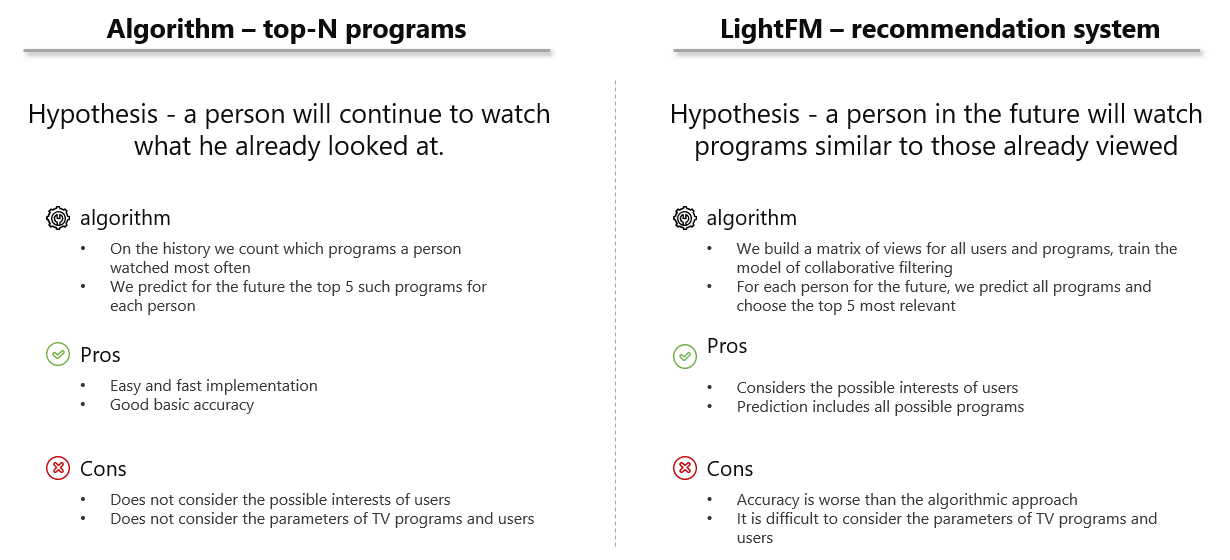

**export_arh_31-42-final.csv** - supplemental information about test data (TV program schedule)

In [26]:
df_info_future = pd.read_csv('export_arh_31-42-final.csv', low_memory=False)

In [27]:
df_show = pd.read_csv('dataset_with_shows.csv')
for c in ['start_time', 'show_start_time', 'stop_time','show_stop_time']:
    df_show[c] = pd.to_datetime(df_show[c])
df_show['start_show_user_time'] = df_show[['show_start_time','start_time']].max(axis=1)
df_show['stop_show_user_time'] = df_show[['stop_time','show_stop_time']].min(axis=1)
df_show['user_watch_time'] = (df_show['stop_show_user_time'] - df_show['start_show_user_time']).dt.total_seconds()
df_show['show_duration'] = (df_show['show_stop_time'] - df_show['show_start_time']).dt.total_seconds()
df_show['user_watch_perc'] = df_show['user_watch_time'] / df_show['show_duration']

In [28]:
# split on holdout by time
train_start_date = df_show.start_time.min()# + datetime.timedelta(days = 4 * 7)
split_date = df_show.start_time.max() - datetime.timedelta(days = 9 * 7)
train = df_show[(df_show.start_time <= split_date) & (df_show.start_time >= train_start_date)].copy()
val = df_show[df_show.start_time > split_date].copy()

In [29]:
# collection of signs and target by views
train_top_views = get_features(train[train['tv_show_id'].isin(val['tv_show_id'].unique())])
val_top_views = get_target(val)
overall_top_movies = train_top_views.groupby(['tv_show_id'], as_index = False)['user_show_freq'].sum().sort_values(['user_show_freq'])['tv_show_id'][-5:].values
overall_top_movies = overall_top_movies[::-1]

In [30]:
# checking the accuracy of the solution
preds = []
trues = []
for user in train_top_views.user_id.unique():
    
    predict_n_movies = train_top_views[train_top_views.user_id == user]['tv_show_id'].values[:5]
    actual_n_movies = val_top_views[val_top_views.user_id == user]['tv_show_id'].values[:5]
    
    if len(predict_n_movies) < 5:
        predict_n_movies = list(predict_n_movies[:len(predict_n_movies)]) + list(overall_top_movies[:5 - len(predict_n_movies)])
    
    
    preds.append(list(predict_n_movies))
    trues.append(list(actual_n_movies))
    
score = np.round(mapk(trues, preds, k = 5), 5)
print(f'MAP@{5} = {score}')

MAP@5 = 0.32872


In [31]:
# view data
df_top_views = get_features(df_show[df_show['tv_show_id'].isin(df_info_future['tv_show_id'].unique())])
overall_top_movies = df_top_views.groupby(['tv_show_id'], as_index = False)['user_show_freq'].sum().sort_values(['user_show_freq'])['tv_show_id'][-5:].values[::-1]

# forecast for the future
submission_df = pd.read_csv('submission.csv')
for index_row, row in submission_df.iterrows():
    pred_n_movies = list(df_top_views[df_top_views.user_id == row['user_id']]['tv_show_id'].values[:5])
    
    if len(pred_n_movies) < 5:
        pred_n_movies = list(pred_n_movies[:len(pred_n_movies)]) + list(overall_top_movies[:5 - len(pred_n_movies)])
    
    pred = ' '.join([str(int(x)) for x in pred_n_movies])
    submission_df.loc[index_row, 'tv_show_id'] = pred
    
submission_df.to_csv('baseline_submission.csv', index = False)

## Final model

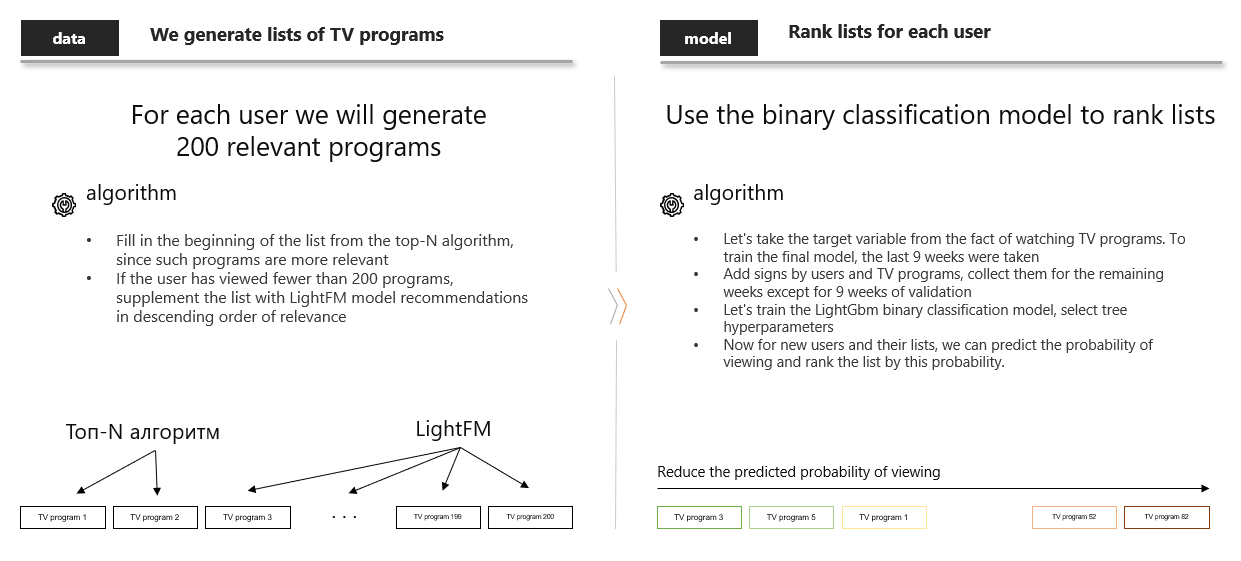

In [34]:
# data from the past
df_info = pd.read_csv('export_arh_11-20-final.csv').append(pd.read_csv('export_arh_21-30-final.csv'))
df_info.start_time = pd.to_datetime(df_info.start_time, format='%d.%m.%Y %H:%M:%S')
df_info['stop_time'] = df_info['start_time'] + pd.to_timedelta(df_info['duration'], unit='s')
df_info = df_info[df_info.tv_show_id != 0].copy()

# data for the future
df_info_future = pd.read_csv('export_arh_31-42-final.csv', low_memory=False)
df_info_future.start_time = pd.to_datetime(df_info_future.start_time, format='%d.%m.%Y %H:%M:%S')
df_info_future['stop_time'] = df_info_future['start_time'] + pd.to_timedelta(df_info_future['duration'], unit='s')
df_info_future = df_info_future[df_info_future.tv_show_id != 0].copy()

# categorical features
for c in ['tv_show_category', 'tv_show_genre_1', 'tv_show_genre_2', 'tv_show_genre_3']:
    df_info[c] = LabelEncoder().fit_transform(df_info[c].fillna('Nope'))

### User_id, tv_show_id encoding for LightFM

In [35]:
for c in ['user_id', 'tv_show_id']:
    _temp = df_show[[c]].drop_duplicates().reset_index(drop = True)
    _temp[f"cont_{c}"] = np.arange(_temp.shape[0])

    df_show = df_show.merge(_temp, on = [c], how = 'left')
    
user_col = 'cont_user_id'
movie_col = 'cont_tv_show_id'

_temp = df_show[['tv_show_id', movie_col]].drop_duplicates()
movies_dict = dict(zip(_temp[movie_col].values, _temp['tv_show_id'].values))

_temp = df_show[['user_id', user_col]].drop_duplicates()
users_dict = dict(zip(_temp[user_col].values, _temp['user_id'].values))

### Checking the solution accuracy on holdout sample

**Split data to train / val**

In [36]:
train_start_date = df_show.start_time.min()
split_date = df_show.start_time.max() - datetime.timedelta(days = 9 * 7) # 9 weeks

train = df_show[(df_show.start_time <= split_date) & (df_show.start_time >= train_start_date)].copy()
df_info_train = df_info[(df_info.start_time <= split_date) & (df_info.start_time >= train_start_date)].copy()

val = df_show[df_show.start_time > split_date].copy()
df_info_val = df_info[df_info.start_time > split_date].copy()

# We remember which TV programs can be validated
possible_movies_in_val = df_info_val.tv_show_id.unique()
print(train.shape, val.shape)

(2537448, 14) (1310248, 14)


**Train LightFm**

In [42]:
# sparse for lightfm
train_sparse = df_to_sparse_interaction_matrix(train)

# fit lightfm
model = LightFM(random_state=42, loss = 'warp')
model.fit(train_sparse, epochs=15, num_threads=4, verbose = False);

# collect user biases
user_bias_df = pd.DataFrame(model.user_biases, columns = ['user_bias_lfm'])
user_bias_df['user_id'] = list(sorted(train[user_col].unique()))
user_bias_df['user_id'] = user_bias_df['user_id'].apply(lambda x: users_dict.get(x))

# collect item biases
show_bias_df = pd.DataFrame(model.item_biases, columns = ['show_bias_lfm'])
show_bias_df['tv_show_id'] = list(sorted(train[movie_col].unique()))
show_bias_df['tv_show_id'] = show_bias_df['tv_show_id'].apply(lambda x: movies_dict.get(x))

# predict the top N current programs for each user from train
train_users = sorted(train[user_col].unique())

# we can only predict films that will definitely be in the target
train_movies = sorted(train[train['tv_show_id'].isin(possible_movies_in_val)][movie_col].unique())

get_n = 200
lightfm_predictions_df = pd.DataFrame()
for train_user in train_users:
    
    all_movies_df = pd.DataFrame(train_movies, columns = [movie_col])
    all_movies_df[user_col] = train_user
    all_movies_df = all_movies_df.astype('int32')
    all_movies_df['lightfm_score'] = model.predict(all_movies_df[user_col].values,
                                                   all_movies_df[movie_col].values)
    all_movies_df.sort_values('lightfm_score', ascending = False, inplace = True)
    all_movies_df['lightfm_rank'] = np.arange(all_movies_df.shape[0])
    
    lightfm_predictions_df = lightfm_predictions_df.append(all_movies_df.head(get_n))
    
lightfm_predictions_df['user_id'] = lightfm_predictions_df[user_col].map(lambda x: users_dict.get(x))
lightfm_predictions_df['tv_show_id'] = lightfm_predictions_df[movie_col].map(lambda x: movies_dict.get(x))
lightfm_predictions_df.head(1)

cont_tv_show_id  cont_user_id  ...              user_id  tv_show_id
19               20             0  ...  7981779138282146703     2400480

[1 rows x 6 columns]

**Choice of N movies for user based on views and LightFm results**

In [43]:
get_n = 200
train_base = train[train['tv_show_id'].isin(possible_movies_in_val)].copy()
val_base = val.copy()
train = get_features(train_base, get_n)
val = get_target(val_base, get_n)
overal_val = get_target(val_base, 10000)
print(train.shape, val.shape)

(165997, 3) (120146, 3)


**Add LightFm as additional lines**

In [44]:
# if incomplete recommendations (user watched <get_n) then add recommendations from lightfm
train_w_lfm = train.copy()
for user, group in train.groupby(['user_id']):
    
    if group.shape[0] < get_n:
        
        need_to_add = get_n - group.shape[0]
        add_tv_show_ids_from_lightfm = lightfm_predictions_df[
            (lightfm_predictions_df.user_id == user)&
            (~lightfm_predictions_df.tv_show_id.isin(group.tv_show_id.unique()))]\
            .tv_show_id.values[:need_to_add]
        
        add_df = pd.DataFrame(add_tv_show_ids_from_lightfm, columns = ['tv_show_id'])
        add_df['user_id'] = user
        add_df['user_show_freq'] = 0
        add_df['user_id'] = add_df['user_id'].astype('uint64')
        
        train_w_lfm = train_w_lfm.append(add_df[['user_id', 'tv_show_id', 'user_show_freq']])
        
assert train.user_id.nunique() == train_w_lfm.user_id.nunique()
assert train_w_lfm.groupby(['user_id']).size().min() == get_n

train_w_lfm = train_w_lfm.merge(lightfm_predictions_df[['user_id', 'tv_show_id', 'lightfm_score']],
            on = ['user_id', 'tv_show_id'], how = 'left')

# combined train
train = train_w_lfm.copy()
train.reset_index(inplace = True, drop = True)

**Add target**

In [45]:
# create target from tv programs that user actually saw in the next 9 weeks
target_col = 'seen'
train = train.merge(overal_val.drop(['user_show_freq'], 1).assign(seen=1), on = ['user_id', 'tv_show_id'], how = 'left')
train[target_col].fillna(0, inplace = True)
print('Target distribution:')
train[target_col].value_counts()

Target distribution:


0.0    907186
1.0     50414
Name: seen, dtype: int64

**Add signs**

In [46]:
# Remove TV programs that have been watched by less than 10 users
shows_watches = train_base[train_base['user_watch_perc'] >= 0.8].groupby(['tv_show_id']).size().reset_index().rename(columns = {0:'show_watched'})
min_watch = 10
shows_watches = shows_watches[shows_watches['show_watched'] > min_watch].copy()
possible_movies_that_matter = shows_watches.tv_show_id.unique()
train = train[train.tv_show_id.isin(possible_movies_that_matter)].copy()
train.reset_index(inplace = True, drop = True)

In [47]:
# collecting signs
train = prepare_features(train, df_info_train, df_info_val, train_base)
train = train.merge(user_bias_df, on = ['user_id'], how = 'left')
train = train.merge(show_bias_df, on = ['tv_show_id'], how = 'left')

**Model validation**

In [48]:
cat_columns = ['tv_show_category', 'tv_show_genre_1', 'tv_show_genre_2', 'tv_show_genre_3']
users_train, users_test = train_test_split(train.user_id.unique(), random_state = 42)

X_train = train[train.user_id.isin(users_train)].copy()
X_test = train[train.user_id.isin(users_test)].copy()
y_train = X_train.pop(target_col)
y_test = X_test.pop(target_col)

X_train = X_train.set_index(["user_id", "tv_show_id"])
X_test = X_test.set_index(["user_id", "tv_show_id"])
print(X_train.shape, X_test.shape)
print('Features:', list(X_train.columns))

(676824, 28) (225161, 28)
Features: ['user_show_freq', 'lightfm_score', 'user_show_rank', 'user_lfm_rank', 'combined_rank', 'channel_id', 'tv_show_category', 'tv_show_genre_1', 'tv_show_genre_2', 'tv_show_genre_3', 'user_show_freq_0.3', 'user_show_freq_0.8', 'alt_user_show_freq_0.3', 'alt_user_show_freq_0.5', 'alt_user_show_freq_0.8', 'user_show_freq_dif_week_1', 'user_show_rank_week_1', 'user_show_rank_mean_week_1', 'alt_user_show_freq_dif_week_1', 'alt_user_show_rank_mean_week_1', 'user_channel_count', 'group_user_show_freq', 'user_show_freq_rel_group', 'tot_show_duration', 'tot_show_duration_future', 'popularity_drop', 'user_bias_lfm', 'show_bias_lfm']


In [49]:
train_data = lgb.Dataset(X_train, y_train)
test_data = lgb.Dataset(X_test, y_test)

param = {
    'task': 'train',
    'objective': 'binary', 
    'metric': 'auc',
    'bagging_fraction': 0.8, 
    'bagging_freq': 4, 
    'colsample_bytree': '0.6', 
    'feature_fraction': 0.75, 
    'learning_rate': 0.01,
    'metric': 'auc',
    'min_data_in_leaf': 20, 
    'num_leaves': 150, 
    'num_threads': 4,
    'reg_alpha': 0.4,
    'reg_lambda': 0.32, 
    'seed': 42,
}

res = {}
bst = lgb.train(
    param, train_data, 
    valid_sets=[train_data, test_data], 
    valid_names=["train", "valid"],
    categorical_feature = cat_columns,
    num_boost_round=10000, evals_result=res, 
    verbose_eval=100, early_stopping_rounds=15)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['tv_show_category', 'tv_show_genre_1', 'tv_show_genre_2', 'tv_show_genre_3']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 15 rounds.
[100]	train's auc: 0.899065	valid's auc: 0.890476
[200]	train's auc: 0.908111	valid's auc: 0.896364
[300]	train's auc: 0.914384	valid's auc: 0.899388
[400]	train's auc: 0.919506	valid's auc: 0.901092
[500]	train's auc: 0.923837	valid's auc: 0.902236
[600]	train's auc: 0.928072	valid's auc: 0.902798
Early stopping, best iteration is:
[587]	train's auc: 0.927361	valid's auc: 0.90281


In [50]:
X_test["lgb_score"] = bst.predict(X_test, num_iteration=bst.best_iteration)
lgb_res = X_test.reset_index([0, 1])[["user_id",
                                        "tv_show_id",
                                        "lgb_score"]].sort_values("lgb_score",
                                                                  ascending=False)

preds = []
trues = []
for user, group in lgb_res.groupby("user_id"):
    predict_n_movies = list(group.tv_show_id)[:5]
    actual_n_movies = val[val.user_id == user]['tv_show_id'].values[:5]
    
    preds.append(list(predict_n_movies))
    trues.append(list(actual_n_movies))
    
score = np.round(mapk(trues, preds, k = 5), 5)
print(f'Model MAP@{5} = {score}')

# reference (baseline)
preds = []
trues = []
for user, group in lgb_res.groupby("user_id"):
    predict_n_movies = train[train.user_id == user]['tv_show_id'].values[:5]
    actual_n_movies = val[val.user_id == user]['tv_show_id'].values[:5]
    
    preds.append(list(predict_n_movies))
    trues.append(list(actual_n_movies))
    
score = np.round(mapk(trues, preds, k = 5), 5)
print(f'Baseline MAP@{5} = {score}')

Model MAP@5 = 0.35283
Baseline MAP@5 = 0.31984


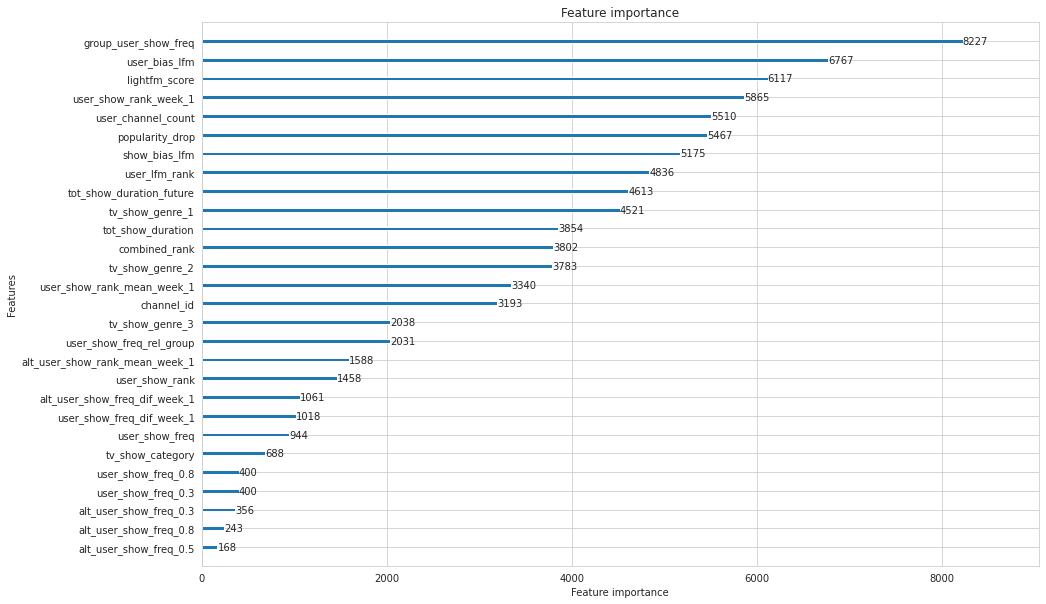

In [51]:
lgb.plot_importance(bst, figsize = (15, 10));

### Final model training

In [52]:
# Full Train
X_train = train.copy()
y_train = X_train.pop(target_col)

X_train = X_train.set_index(["user_id", "tv_show_id"])
train_data = lgb.Dataset(X_train, y_train)

final_model = lgb.train(
    param, train_data, 
    categorical_feature = cat_columns,
    num_boost_round=bst.best_iteration+100, verbose_eval=False)

final_model.save_model('tuned_.txt')

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['tv_show_category', 'tv_show_genre_1', 'tv_show_genre_2', 'tv_show_genre_3']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


### Implementation details

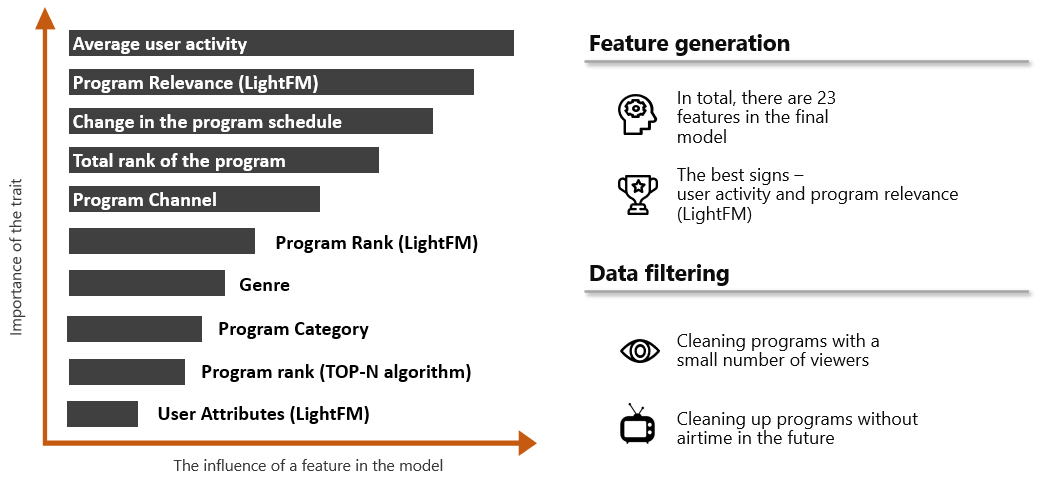

### Collection of final data and forecast submission

**Update trained Lightfm model, now with all data**

In [54]:
# sparse for lightfm
df_sparse = df_to_sparse_interaction_matrix(df_show)

# fit lightfm
lfm_final_model = LightFM(random_state=42, loss = 'warp')
lfm_final_model.fit(df_sparse, epochs=15, num_threads=4, verbose = False);

# predict the top N current programs for each user from train
train_users = sorted(df_show[user_col].unique())

# we can only predict films that will definitely be in the target
train_movies = sorted(df_show[df_show.tv_show_id.isin(df_info_future['tv_show_id'].unique())][movie_col].unique())

# collect user biases
df_user_bias_df = pd.DataFrame(lfm_final_model.user_biases, columns = ['user_bias_lfm'])
df_user_bias_df['user_id'] = list(sorted(df_show[user_col].unique()))
df_user_bias_df['user_id'] = df_user_bias_df['user_id'].apply(lambda x: users_dict.get(x))

# collect item biases
df_show_bias_df = pd.DataFrame(lfm_final_model.item_biases, columns = ['show_bias_lfm'])
df_show_bias_df['tv_show_id'] = list(sorted(df_show[movie_col].unique()))
df_show_bias_df['tv_show_id'] = df_show_bias_df['tv_show_id'].apply(lambda x: movies_dict.get(x))

# collect Lightfm recommendations for all users in the train
get_n = 200
df_lightfm_predictions_df = pd.DataFrame()
for train_user in train_users:
    
    all_movies_df = pd.DataFrame(train_movies, columns = [movie_col])
    all_movies_df[user_col] = train_user
    all_movies_df = all_movies_df.astype('int32')
    all_movies_df['lightfm_score'] = lfm_final_model.predict(all_movies_df[user_col].values,
                                                             all_movies_df[movie_col].values)
    all_movies_df.sort_values('lightfm_score', ascending = False, inplace = True)
    all_movies_df['lightfm_rank'] = np.arange(all_movies_df.shape[0])
    
    df_lightfm_predictions_df = df_lightfm_predictions_df.append(all_movies_df.head(get_n), sort = False)
    
df_lightfm_predictions_df['user_id'] = df_lightfm_predictions_df[user_col].map(lambda x: users_dict.get(x))
df_lightfm_predictions_df['tv_show_id'] = df_lightfm_predictions_df[movie_col].map(lambda x: movies_dict.get(x))
assert df_lightfm_predictions_df.user_id.nunique() == len(train_users)
df_lightfm_predictions_df.head(1)

cont_tv_show_id  cont_user_id  ...              user_id  tv_show_id
20               20             0  ...  7981779138282146703     2400480

[1 rows x 6 columns]

**Collecting basic features, enriching with recommendations from LightFM**

In [55]:
# Basic recommendations - according to the top views
print(df_show.shape)
get_n = 200

possible_test_movies = df_info_future['tv_show_id'].unique()
df_show_base = df_show[df_show['tv_show_id'].isin(possible_test_movies)].copy()
df_show_train = get_features(df_show_base, get_n)
overall_top_movies = df_show_train.groupby(['tv_show_id'], as_index = False)['user_show_freq'].sum().sort_values(['user_show_freq'])['tv_show_id'][-5:].values[::-1]

(3847696, 14)


In [56]:
# if incomplete recommendations (user watched <get_n) then add recommendations from lightfm
df_train_w_lfm = df_show_train.copy()
for user, group in df_show_train.groupby(['user_id']):
    
    if group.shape[0] < get_n:
        
        need_to_add = get_n - group.shape[0]
        add_tv_show_ids_from_lightfm = df_lightfm_predictions_df[
            (df_lightfm_predictions_df.user_id == user)&
            (~df_lightfm_predictions_df.tv_show_id.isin(group.tv_show_id.unique()))]\
            .tv_show_id.values[:need_to_add]
        
        add_df = pd.DataFrame(add_tv_show_ids_from_lightfm, columns = ['tv_show_id'])
        add_df['user_id'] = user
        add_df['user_show_freq'] = 0
        add_df['user_id'] = add_df['user_id'].astype('uint64')
        
        df_train_w_lfm = df_train_w_lfm.append(add_df[['user_id', 'tv_show_id', 'user_show_freq']])
        
assert df_show_train.user_id.nunique() == df_train_w_lfm.user_id.nunique()
assert df_train_w_lfm.groupby(['user_id']).size().min() == get_n

df_train_w_lfm = df_train_w_lfm.merge(df_lightfm_predictions_df[['user_id', 'tv_show_id', 'lightfm_score']],
            on = ['user_id', 'tv_show_id'], how = 'left')

# combined train
df_show_train = df_train_w_lfm.copy()
df_show_train.reset_index(inplace = True, drop = True)

**Post-processing and adding features**

In [57]:
# remove low-count movies
shows_watches = df_show_base[df_show_base['user_watch_perc'] >= 0.8].groupby(['tv_show_id']).size().reset_index().rename(columns = {0:'show_watched'})
min_watch = 10
shows_watches = shows_watches[shows_watches['show_watched'] > 10].copy()
possible_movies_that_matter = shows_watches.tv_show_id.unique()
df_show_train = df_show_train[df_show_train.tv_show_id.isin(possible_movies_that_matter)].copy()
df_show_train.reset_index(inplace = True, drop = True)

# collect features
df_show_train = prepare_features(df_show_train, df_info, df_info_future, df_show_base)
df_show_train = df_show_train.merge(df_user_bias_df, on = ['user_id'], how = 'left')
df_show_train = df_show_train.merge(df_show_bias_df, on = ['tv_show_id'], how = 'left')
print(df_show_train.shape)

(946395, 30)


**Prediction submission**

In [58]:
# predict rank score
X_predict = df_show_train.copy()
X_predict = X_predict.set_index(["user_id", "tv_show_id"])[X_train.columns]
X_predict["lgb_score"] = final_model.predict(X_predict, num_iteration=bst.best_iteration)

In [59]:
pred_res = X_predict.reset_index([0, 1])[["user_id",
                                        "tv_show_id",
                                        "lgb_score"]].sort_values("lgb_score",
                                                                  ascending=False)

In [61]:
# create submission
submission_df = pd.read_csv('submission.csv')
for index_row, row in submission_df.iterrows():
    pred_n_movies = list(pred_res[pred_res.user_id == row['user_id']]['tv_show_id'].values[:5])
    
    if len(pred_n_movies) < 5:
        pred_n_movies = list(pred_n_movies[:len(pred_n_movies)]) + list(overall_top_movies[:5 - len(pred_n_movies)])
    
    pred = ' '.join([str(int(x)) for x in pred_n_movies])
    submission_df.loc[index_row, 'tv_show_id'] = pred
    
submission_df.to_csv('lfm_lgb6_submission.csv', index = False)
submission_df.head()

user_id                                    tv_show_id
0  8377619604347126107          240081 2400480 2400508 20088 2400467
1  8381667675275833309       2400480 240081 6700482 12001682 2400467
2  8387147770138767246  12001682 12002856 12001732 12002355 12002955
3  8397181578236218580          240081 2400480 20088 2400467 6700482
4  8404698046253197367           2400480 240081 20088 6200371 200432

## References
1. https://github.com/ndmel/2nd_place_recsys_cinema_challenge_2020 `code`
2. https://www.kaggle.com/c/sweettv-tv-program-recommender/overview `data`
3. [Google Image search service](https://www.google.com/search?q=sweet.tv+site&rlz=1C1GCEA_enIN909IN909&sxsrf=ALeKk00uJsjmdu5iUacItcKSdysJYoih4w:1626998276475&source=lnms&tbm=isch&sa=X&ved=2ahUKEwj0tMby8PfxAhUf63MBHY7TCnEQ_AUoA3oECAEQBQ&biw=1366&bih=657) `site`
4. [Sweet.tv official site](https://sweet.tv/) `site`
5. [Google Translate service](https://translate.google.co.in/) `api`
6. [Microsoft PPT Translation service](https://translator.microsoft.com/) `api`